In [81]:
import os
import sys
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

sys.path.append('..')
sys.path.append('../..')

from library import ModelStatistics, SemanticHeterogenityRegularizer
from library import custom_fit_offline, weigh_average
from library import BleiTopTokens

import artm

%load_ext autoreload

In [2]:
from library.base_coherence_score import BaseCoherenceScore
from library.top_tokens_coherence_score import TopTokensCoherenceScore

In [3]:
from topicnet.cooking_machine import Dataset
from topicnet.cooking_machine.models import TopicModel

In [4]:
LOAD_PS = False

In [5]:
if LOAD_PS:
    DATA_PATH = '../data/ps.vw'
    BATCH_PATH = '../data/ps_batches'
    DICT_PATH = '../data/ps.dict'

    batch_vectorizer_ps = artm.BatchVectorizer(
        data_path=DATA_PATH,
        data_format='vowpal_wabbit', 
        target_folder=BATCH_PATH
    )

    dictionary_ps = artm.Dictionary()
    if not os.path.isfile(DICT_PATH):
        dictionary_ps.gather(data_path=batch_vectorizer_ps.data_path)
        dictionary_ps.save(DICT_PATH)
    dictionary_ps.load(DICT_PATH)

    dictionary_ps.filter(min_tf=5, max_df=2000)#, min_df_rate=0.01)

else:
    DATA_PATH = '../data/lenta_22.vw'
    BATCH_PATH = '../data/lenta_22_batches'
    DICT_PATH = '../data/lenta_22.dict'

    batch_vectorizer_lenta = artm.BatchVectorizer(
        data_path=DATA_PATH,
        data_format='vowpal_wabbit', 
        target_folder=BATCH_PATH
    )

    dictionary_lenta = artm.Dictionary()
    if not os.path.isfile(DICT_PATH):
        dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
        dictionary_lenta.save(DICT_PATH)
    dictionary_lenta.load(DICT_PATH)

    dictionary_lenta.filter(min_tf=5, max_df=2000)#, min_df_rate=0.01)

### Experiment model

#### Train basic model

In [6]:
num_topics = 22

In [7]:
model = artm.ARTM(num_topics=num_topics, cache_theta=True)#, class_ids={'@2gramm': 1, '@3gramm': 1, '@text': 1})
model.scores.add(artm.scores.PerplexityScore(name='perplexity'))

if LOAD_PS:
    model.initialize(dictionary_ps)
    model.fit_offline(batch_vectorizer_ps, 15)
else:
    model.initialize(dictionary_lenta)
    model.fit_offline(batch_vectorizer_lenta, 15)

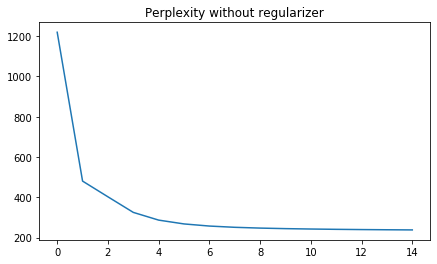

In [8]:
plt.figure(figsize=(7,4))

values = np.array(model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

#### Calculate basic statistics

In [ ]:
statistics = ModelStatistics(model)

basic_stat = statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

In [ ]:
dataset = Dataset('../data/lenta_22.csv')
topic_model = TopicModel(artm_model=model)

basic_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
basic_top_coherence.call(topic_model)

In [9]:
basic_top_tokens = BleiTopTokens(15).view(model.get_phi())

театр +
животные +
космос
самолет
матчи (футбол) - слилось с хоккеем, видимо
компания, конкурс?
фильмы 
сеть шоу
ученые исследования
ученые звёзды
суд +
ученые биология врач
дом житель местный город
дом особняк продажа
космос, планета
рубли, недвижимость
украина +
бокс +
музыка +
телевидение +
белоруссия +
фильмы, сериалы

2 космоса
2 кино
много ученых
нет книг
самолет отдельно

['Белоруссия', 'Украина', 'Следствие и суд', 'Хоккей', 'Футбол', 'Квартира', 'Музыка', 
                    'Бокс и ММА', 'Звери', 'Театр', 'Оружие', 'Дача', 'Наука', 'Кино', 'ТВ и радио', 
                    'Космос', 'Авто', 'Книги', 'Туризм', 'Еда', 'Игры', 'Мемы']

#### Add regularizer to the model

In [ ]:
if LOAD_PS:
    custom_regularizers = [
        SemanticHeterogenityRegularizer('heterogenity', 0.001, statistics, batch_vectorizer_ps)
    ]
    custom_fit_offline(model, custom_regularizers, batch_vectorizer_ps, 15)
else:
    custom_regularizers = [
        SemanticHeterogenityRegularizer('heterogenity', 0.001, statistics, batch_vectorizer_lenta)
    ]
    custom_fit_offline(model, custom_regularizers, batch_vectorizer_lenta, 15)

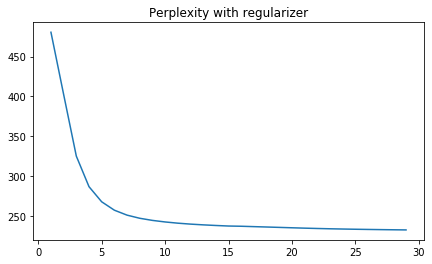

In [20]:
plt.figure(figsize=(7,4))

values = np.array(model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

#### Calculate regularizer statistics

In [ ]:
reg_statistics = ModelStatistics(model)

reg_stat = reg_statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

In [ ]:
reg_topic_model = TopicModel(artm_model=model)

reg_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
reg_top_coherence.call(reg_topic_model)

In [ ]:
reg_top_tokens = BleiTopTokens(15).view(model.get_phi())

In [19]:
basic_top_tokens

{'topic_0': {'values': array([1.90991502, 0.69889199, 0.46743278, 0.46689946, 0.46506206,
         0.42252149, 0.41357306, 0.39522288, 0.35871601, 0.35740264,
         0.35349574, 0.33785045, 0.33764156, 0.32635357, 0.3247461 ]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'режиссёр'),
   ('text', 'стать'),
   ('text', 'артист'),
   ('text', 'постановка'),
   ('text', 'россия'),
   ('text', 'москва'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'фестиваль'),
   ('text', 'сцена'),
   ('text', 'премия')]},
 'topic_1': {'values': array([0.57767531, 0.43619176, 0.4033304 , 0.35792752, 0.32323336,
         0.24791012, 0.24766247, 0.24475547, 0.23982047, 0.23252692,
         0.21860843, 0.20876311, 0.20172915, 0.19993267, 0.19660774]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', '<mail>'),
   ('text', 'тысяча

In [18]:
reg_top_tokens

{'topic_0': {'values': array([0.3999633 , 0.13565478, 0.0969674 , 0.08544988, 0.08491338,
         0.07833789, 0.0778382 , 0.07675842, 0.07194477, 0.07180085,
         0.07150629, 0.06252678, 0.06059284, 0.0587487 , 0.05708977]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.13530917, 0.09373189, 0.08514059, 0.06390734, 0.05410282,
         0.04897992, 0.0487725 , 0.043046  , 0.04265949, 0.03860168,
         0.03833763, 0.03814006, 0.03780654, 0.03778961, 0.03765666]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'тысяча'),
   ('text', 'кошка')

In [53]:
np.array(list(basic_top_coherence.topic_coherences.values())).mean()

0.30472531335416025

In [52]:
np.array(list(reg_top_coherence.topic_coherences.values())).mean()

0.3063040584039166

In [54]:
basic_top_coherence.topic_coherences.values()

dict_values([0.22239024918586175, 0.14601122042888454, 0.30712031209017604, 0.2769115791415537, 0.46338657171701203, 0.1895199524893696, 0.22258893148265185, 0.16791980883861754, 0.2553915987289095, 0.33770063328101285, 0.3404026819489025, 0.2815066303845589, 0.227846584585461, 0.4976711827394213, 0.3518321500004205, 0.4997003646489185, 0.3579584740326126, 0.4743399435944484, 0.1744498770700338, 0.2899293015564555, 0.3387070906869893, 0.28067175515925574])

In [55]:
reg_top_coherence.topic_coherences.values()

dict_values([0.2224101240848729, 0.14834201794089308, 0.39511930657350397, 0.2810947777363682, 0.4535296712163156, 0.1905182547337079, 0.20193735984401132, 0.16575337343929605, 0.2162494775822889, 0.35189861370476283, 0.3404026819489025, 0.28027963289420155, 0.22061505581542187, 0.49302129481512597, 0.35798115096818955, 0.516688351296709, 0.36596849857743663, 0.4677111390960344, 0.1744498770700338, 0.29856883209441254, 0.32202991237202533, 0.2741198810816509])

### Dummy basic model

In [21]:
num_topics = 22

In [27]:
dummy_model = artm.ARTM(num_topics=num_topics, cache_theta=True)#, class_ids={'@2gramm': 1, '@3gramm': 1, '@text': 1})
dummy_model.scores.add(artm.scores.PerplexityScore(name='perplexity'))

dummy_model.initialize(dictionary_lenta)
dummy_model.fit_offline(batch_vectorizer_lenta, 30)

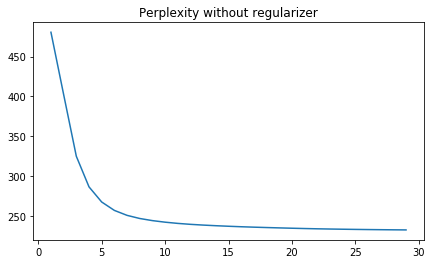

In [28]:
plt.figure(figsize=(7,4))

values = np.array(dummy_model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [29]:
dummy_top_tokens = BleiTopTokens(15).view(dummy_model.get_phi())

In [25]:
dummy_top_tokens

{'topic_0': {'values': array([2.33025255, 0.8555392 , 0.626846  , 0.56183545, 0.55919472,
         0.51493079, 0.51159838, 0.50874956, 0.47960339, 0.47754971,
         0.47349257, 0.42055538, 0.41131401, 0.39755245, 0.38605252]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.85003689, 0.60924641, 0.55668007, 0.4468395 , 0.37665487,
         0.33544589, 0.33153957, 0.29975927, 0.29389175, 0.27420646,
         0.26974053, 0.26935202, 0.26772653, 0.26731571, 0.26516978]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'кошка'),
   ('text', 'тысяча')

In [26]:
reg_top_tokens

{'topic_0': {'values': array([0.3999633 , 0.13565478, 0.0969674 , 0.08544988, 0.08491338,
         0.07833789, 0.0778382 , 0.07675842, 0.07194477, 0.07180085,
         0.07150629, 0.06252678, 0.06059284, 0.0587487 , 0.05708977]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.13530917, 0.09373189, 0.08514059, 0.06390734, 0.05410282,
         0.04897992, 0.0487725 , 0.043046  , 0.04265949, 0.03860168,
         0.03833763, 0.03814006, 0.03780654, 0.03778961, 0.03765666]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'тысяча'),
   ('text', 'кошка')

### Model with higher tau

#### Train basic model

In [ ]:
num_topics = 22

In [ ]:
add_model = artm.ARTM(num_topics=num_topics, cache_theta=True)#, class_ids={'@2gramm': 1, '@3gramm': 1, '@text': 1})
add_model.scores.add(artm.scores.PerplexityScore(name='perplexity'))

add_model.initialize(dictionary_lenta)
add_model.fit_offline(batch_vectorizer_lenta, 15)

#### Calculate basic statistics

In [ ]:
add_statistics = ModelStatistics(add_model)

add_basic_stat = add_statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

In [ ]:
dataset = Dataset('../data/lenta_22.csv')
add_topic_model = TopicModel(artm_model=model)

add_basic_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
add_basic_top_coherence.call(add_topic_model)

In [9]:
add_basic_top_tokens = BleiTopTokens(15).view(model.get_phi())

#### Add regularizer to the model

In [ ]:
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 0.01, statistics, batch_vectorizer_lenta)
]
custom_fit_offline(add_model, custom_regularizers, batch_vectorizer_lenta, 15)

#### Calculate regularizer statistics

In [ ]:
add_reg_statistics = ModelStatistics(add_model)

add_reg_stat = add_reg_statistics.calculate_topic_statistics(batch_vectorizer_lenta, calculate_n=True)

In [ ]:
add_reg_topic_model = TopicModel(artm_model=add_model)

add_reg_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
add_reg_top_coherence.call(add_reg_topic_model)

In [ ]:
reg_top_tokens = BleiTopTokens(15).view(model.get_phi())

In [19]:
basic_top_tokens

{'topic_0': {'values': array([1.90991502, 0.69889199, 0.46743278, 0.46689946, 0.46506206,
         0.42252149, 0.41357306, 0.39522288, 0.35871601, 0.35740264,
         0.35349574, 0.33785045, 0.33764156, 0.32635357, 0.3247461 ]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'режиссёр'),
   ('text', 'стать'),
   ('text', 'артист'),
   ('text', 'постановка'),
   ('text', 'россия'),
   ('text', 'москва'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'фестиваль'),
   ('text', 'сцена'),
   ('text', 'премия')]},
 'topic_1': {'values': array([0.57767531, 0.43619176, 0.4033304 , 0.35792752, 0.32323336,
         0.24791012, 0.24766247, 0.24475547, 0.23982047, 0.23252692,
         0.21860843, 0.20876311, 0.20172915, 0.19993267, 0.19660774]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', '<mail>'),
   ('text', 'тысяча

In [18]:
reg_top_tokens

{'topic_0': {'values': array([0.3999633 , 0.13565478, 0.0969674 , 0.08544988, 0.08491338,
         0.07833789, 0.0778382 , 0.07675842, 0.07194477, 0.07180085,
         0.07150629, 0.06252678, 0.06059284, 0.0587487 , 0.05708977]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.13530917, 0.09373189, 0.08514059, 0.06390734, 0.05410282,
         0.04897992, 0.0487725 , 0.043046  , 0.04265949, 0.03860168,
         0.03833763, 0.03814006, 0.03780654, 0.03778961, 0.03765666]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'тысяча'),
   ('text', 'кошка')

# Additional model

In [56]:
LOAD_PS = True

In [57]:
if LOAD_PS:
    DATA_PATH = '../data/ps.vw'
    BATCH_PATH = '../data/ps_batches'
    DICT_PATH = '../data/ps.dict'

    batch_vectorizer_ps = artm.BatchVectorizer(
        data_path=DATA_PATH,
        data_format='vowpal_wabbit', 
        target_folder=BATCH_PATH
    )

    dictionary_ps = artm.Dictionary()
    if not os.path.isfile(DICT_PATH):
        dictionary_ps.gather(data_path=batch_vectorizer_ps.data_path)
        dictionary_ps.save(DICT_PATH)
    dictionary_ps.load(DICT_PATH)

    dictionary_ps.filter(min_tf=5, max_df=2000)#, min_df_rate=0.01)

else:
    DATA_PATH = '../data/lenta_22.vw'
    BATCH_PATH = '../data/lenta_22_batches'
    DICT_PATH = '../data/lenta_22.dict'

    batch_vectorizer_lenta = artm.BatchVectorizer(
        data_path=DATA_PATH,
        data_format='vowpal_wabbit', 
        target_folder=BATCH_PATH
    )

    dictionary_lenta = artm.Dictionary()
    if not os.path.isfile(DICT_PATH):
        dictionary_lenta.gather(data_path=batch_vectorizer_lenta.data_path)
        dictionary_lenta.save(DICT_PATH)
    dictionary_lenta.load(DICT_PATH)

    dictionary_lenta.filter(min_tf=5, max_df=2000)#, min_df_rate=0.01)

### Experiment model

#### Train basic model

In [71]:
num_topics = 20

In [72]:
ps_model = artm.ARTM(num_topics=num_topics, cache_theta=True)#, class_ids={'@2gramm': 1, '@3gramm': 1, '@text': 1})
ps_model.scores.add(artm.scores.PerplexityScore(name='perplexity'))

ps_model.initialize(dictionary_ps)
ps_model.fit_offline(batch_vectorizer_ps, 15)

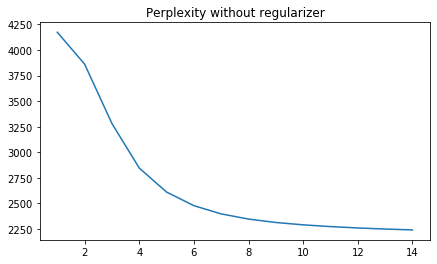

In [73]:
plt.figure(figsize=(7,4))

values = np.array(ps_model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

#### Calculate basic statistics

In [ ]:
ps_statistics = ModelStatistics(ps_model)

ps_basic_stat = ps_statistics.calculate_topic_statistics(batch_vectorizer_ps, calculate_n=True)

In [77]:
ps_basic_stat

(array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([0.44748307, 0.46176891, 0.40967878, 0.44739199, 0.42271536,
        0.36596998, 0.42750694, 0.45263563, 0.43717029, 0.43519257,
        0.4077793 , 0.45925473, 0.45396806, 0.41677889, 0.45458922,
        0.43512237, 0.40648351, 0.42434579, 0.39067403, 0.44337638]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan]),
 array([0.46333365, 0.52253983, 0.35966505, 0.46614368, 0.45838051,
        0.38423256, 0.44780672, 0.46863472, 0.44643416, 0.4950663 ,


In [ ]:
dataset = Dataset('../data/lenta_22.csv')
ps_topic_model = TopicModel(artm_model=ps_model)

basic_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
basic_top_coherence.call(topic_model)

In [9]:
basic_top_tokens = BleiTopTokens(15).view(model.get_phi())

#### Add regularizer to the model

In [ ]:
custom_regularizers = [
    SemanticHeterogenityRegularizer('heterogenity', 0.001, statistics, batch_vectorizer_ps)
]
custom_fit_offline(ps_model, custom_regularizers, batch_vectorizer_ps, 15)

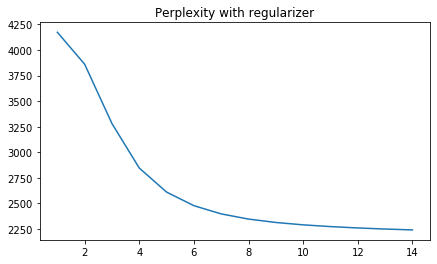

In [76]:
plt.figure(figsize=(7,4))

values = np.array(ps_model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity with regularizer')
plt.plot(values)

#### Calculate regularizer statistics

In [82]:
ps_reg_statistics = ModelStatistics(ps_model)

ps_reg_stat = ps_reg_statistics.calculate_topic_statistics(batch_vectorizer_ps, calculate_n=True)

../library/statistics.py:131: RuntimeWarning: invalid value encountered in true_divide
  model_loss = np.log(self.nwd / self.nd / self.pwd + (self.nwd == 0).astype(int))
../library/statistics.py:131: RuntimeWarning: invalid value encountered in log
  model_loss = np.log(self.nwd / self.nd / self.pwd + (self.nwd == 0).astype(int))
../library/statistics.py:139: RuntimeWarning: invalid value encountered in true_divide
  ntwd_t = self.nwd * ptwd_t / self.pwd
../library/statistics.py:157: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)
../library/statistics.py:165: RuntimeWarning: invalid value encountered in true_divide
  ntwd_t = self.nwd * ptwd_t / self.pwd


In [85]:
import library.statistics 

In [ ]:
ps_reg_statistics = library.statistics.ModelStatistics(ps_model)

ps_reg_stat = ps_reg_statistics.calculate_topic_statistics(batch_vectorizer_ps, calculate_n=True)

../library/statistics.py:131: RuntimeWarning: invalid value encountered in true_divide
  model_loss = np.log(self.nwd / self.nd / self.pwd + (self.nwd == 0).astype(int))
../library/statistics.py:131: RuntimeWarning: invalid value encountered in log
  model_loss = np.log(self.nwd / self.nd / self.pwd + (self.nwd == 0).astype(int))
../library/statistics.py:139: RuntimeWarning: invalid value encountered in true_divide
  ntwd_t = self.nwd * ptwd_t / self.pwd
../library/statistics.py:157: RuntimeWarning: divide by zero encountered in log
  model_loss = np.log(self.phi.values / phi_safe)
../library/statistics.py:165: RuntimeWarning: invalid value encountered in true_divide
  ntwd_t = self.nwd * ptwd_t / self.pwd


In [ ]:
reg_topic_model = TopicModel(artm_model=ps_model)

reg_top_coherence = TopTokensCoherenceScore(dataset, num_top_words=20)
reg_top_coherence.call(reg_topic_model)

In [ ]:
reg_top_tokens = BleiTopTokens(15).view(model.get_phi())

In [19]:
basic_top_tokens

{'topic_0': {'values': array([1.90991502, 0.69889199, 0.46743278, 0.46689946, 0.46506206,
         0.42252149, 0.41357306, 0.39522288, 0.35871601, 0.35740264,
         0.35349574, 0.33785045, 0.33764156, 0.32635357, 0.3247461 ]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'режиссёр'),
   ('text', 'стать'),
   ('text', 'артист'),
   ('text', 'постановка'),
   ('text', 'россия'),
   ('text', 'москва'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'фестиваль'),
   ('text', 'сцена'),
   ('text', 'премия')]},
 'topic_1': {'values': array([0.57767531, 0.43619176, 0.4033304 , 0.35792752, 0.32323336,
         0.24791012, 0.24766247, 0.24475547, 0.23982047, 0.23252692,
         0.21860843, 0.20876311, 0.20172915, 0.19993267, 0.19660774]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', '<mail>'),
   ('text', 'тысяча

In [18]:
reg_top_tokens

{'topic_0': {'values': array([0.3999633 , 0.13565478, 0.0969674 , 0.08544988, 0.08491338,
         0.07833789, 0.0778382 , 0.07675842, 0.07194477, 0.07180085,
         0.07150629, 0.06252678, 0.06059284, 0.0587487 , 0.05708977]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.13530917, 0.09373189, 0.08514059, 0.06390734, 0.05410282,
         0.04897992, 0.0487725 , 0.043046  , 0.04265949, 0.03860168,
         0.03833763, 0.03814006, 0.03780654, 0.03778961, 0.03765666]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'тысяча'),
   ('text', 'кошка')

In [53]:
np.array(list(basic_top_coherence.topic_coherences.values())).mean()

0.30472531335416025

In [52]:
np.array(list(reg_top_coherence.topic_coherences.values())).mean()

0.3063040584039166

In [54]:
basic_top_coherence.topic_coherences.values()

dict_values([0.22239024918586175, 0.14601122042888454, 0.30712031209017604, 0.2769115791415537, 0.46338657171701203, 0.1895199524893696, 0.22258893148265185, 0.16791980883861754, 0.2553915987289095, 0.33770063328101285, 0.3404026819489025, 0.2815066303845589, 0.227846584585461, 0.4976711827394213, 0.3518321500004205, 0.4997003646489185, 0.3579584740326126, 0.4743399435944484, 0.1744498770700338, 0.2899293015564555, 0.3387070906869893, 0.28067175515925574])

In [55]:
reg_top_coherence.topic_coherences.values()

dict_values([0.2224101240848729, 0.14834201794089308, 0.39511930657350397, 0.2810947777363682, 0.4535296712163156, 0.1905182547337079, 0.20193735984401132, 0.16575337343929605, 0.2162494775822889, 0.35189861370476283, 0.3404026819489025, 0.28027963289420155, 0.22061505581542187, 0.49302129481512597, 0.35798115096818955, 0.516688351296709, 0.36596849857743663, 0.4677111390960344, 0.1744498770700338, 0.29856883209441254, 0.32202991237202533, 0.2741198810816509])

### Dummy basic model

In [21]:
num_topics = 22

In [27]:
dummy_model = artm.ARTM(num_topics=num_topics, cache_theta=True)#, class_ids={'@2gramm': 1, '@3gramm': 1, '@text': 1})
dummy_model.scores.add(artm.scores.PerplexityScore(name='perplexity'))

dummy_model.initialize(dictionary_lenta)
dummy_model.fit_offline(batch_vectorizer_lenta, 30)

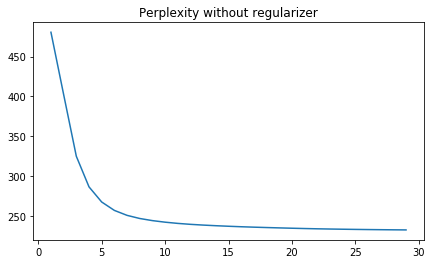

In [28]:
plt.figure(figsize=(7,4))

values = np.array(dummy_model.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity without regularizer')
plt.plot(values)

In [29]:
dummy_top_tokens = BleiTopTokens(15).view(dummy_model.get_phi())

In [25]:
dummy_top_tokens

{'topic_0': {'values': array([2.33025255, 0.8555392 , 0.626846  , 0.56183545, 0.55919472,
         0.51493079, 0.51159838, 0.50874956, 0.47960339, 0.47754971,
         0.47349257, 0.42055538, 0.41131401, 0.39755245, 0.38605252]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.85003689, 0.60924641, 0.55668007, 0.4468395 , 0.37665487,
         0.33544589, 0.33153957, 0.29975927, 0.29389175, 0.27420646,
         0.26974053, 0.26935202, 0.26772653, 0.26731571, 0.26516978]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'кошка'),
   ('text', 'тысяча')

In [26]:
reg_top_tokens

{'topic_0': {'values': array([0.3999633 , 0.13565478, 0.0969674 , 0.08544988, 0.08491338,
         0.07833789, 0.0778382 , 0.07675842, 0.07194477, 0.07180085,
         0.07150629, 0.06252678, 0.06059284, 0.0587487 , 0.05708977]),
  'tokens': [('text', 'театр'),
   ('text', 'спектакль'),
   ('text', 'режиссёр'),
   ('text', 'имя'),
   ('text', 'культура'),
   ('text', 'москва'),
   ('text', 'россия'),
   ('text', 'стать'),
   ('text', 'постановка'),
   ('text', 'артист'),
   ('text', 'фестиваль'),
   ('text', 'большой'),
   ('text', 'руководитель'),
   ('text', 'сцена'),
   ('text', 'опера')]},
 'topic_1': {'values': array([0.13530917, 0.09373189, 0.08514059, 0.06390734, 0.05410282,
         0.04897992, 0.0487725 , 0.043046  , 0.04265949, 0.03860168,
         0.03833763, 0.03814006, 0.03780654, 0.03778961, 0.03765666]),
  'tokens': [('text', 'животное'),
   ('text', 'животный'),
   ('text', 'собака'),
   ('text', 'штат'),
   ('text', 'когда'),
   ('text', 'тысяча'),
   ('text', 'кошка')